## 데이터 불러오기


In [ ]:
# 각자의 데이터가 있는 위치를 지정해주시면 됩니다.
file_directory = '/content/drive/MyDrive/Colab Notebooks/코드잇_초급프로젝트1/data'
os.chdir(file_directory)


In [ ]:
globals_dict = globals()

start_year = 2016
end_year = 2024
df_month = pd.DataFrame(columns=['년월', '무임승차 합계'])
df_line_month = pd.DataFrame(columns=['년월', '호선명', '무임승차'])


# 2016년 1월부터 2024년 6월까지 for loop
for year in range(start_year, end_year+1):
    for month in range(1, 13):
        # 2024년 7월 이후는 제외
        if year == end_year and month > 6:
            break
        # 년도와 월을 문자열로 변환
        years_month = f"{year}_{str(month).zfill(2)}"

        # xls 파일 경로 (년월에 따라 다른 파일을 불러오는 경우)
        filename = f"subway_data/{year}/{year}{str(month).zfill(2)}_교통카드_통계자료.xls"

        # xls 파일 불러오기(sheet는 '버스정류장별 이용현황', '지하철 노선별 역별 이용현황', '지하철 유무임별 이용현황', '지하철 시간대별 이용현황')
        df = pd.read_excel(filename, sheet_name='지하철 유무임별 이용현황')

        df['유임승차'] = df['유임승차'].str.replace(',', '').astype(int)
        df['유임하차'] = df['유임하차'].str.replace(',', '').astype(int)
        df['무임승차'] = df['무임승차'].str.replace(',', '').astype(int)
        df['무임하차'] = df['무임하차'].str.replace(',', '').astype(int)

        # 전역 변수로 저장
        globals_dict[f'df_{years_month}'] = df

        #년월별로 무임승차 합
        month_free_rides = globals_dict[f'df_{years_month}']['무임승차'].sum()
        month_pay_rides = globals_dict[f'df_{years_month}']['유임승차'].sum()

        #년월별 무임승차 합이 나온 DataFrame
        df_temp = pd.DataFrame({
            '년월': [years_month],
            '무임승차 합계': [month_free_rides],
            '유임승차 합계': [month_pay_rides]
        })
        df_line = df.groupby('호선명')['무임승차'].sum().reset_index()
        df_line['년월'] = years_month

        # df_line_month에 df_line을 추가
        df_line_month = pd.concat([df_line_month, df_line], ignore_index=True)

        #df_month에 df_temp를 추가
        df_month = pd.concat([df_month, df_temp], ignore_index=True)

print("파일을 전부 load 했습니다.")


In [ ]:
# 년월별 무임승차, 유임승차의 합계값
df_month

In [ ]:
## 년월에 따른 호선별 무임승차합산
df_line_month

In [ ]:
# 윈도우 기준 encoding을 'cp949', 다른 환경에서는 'utf-8'
df_month.to_csv('df_month.csv', index=False, encoding='cp949')

In [ ]:
# 24년도 기준 고령자 현황표(24년도만 1/4분기에 조사된 내용으로 기입했습니다. 그외 연도별 65세 이상인구는 4분기 조사 내용으로 넣었습니다.)
df_old = pd.read_excel('static_data/24년_고령자현황.xls', sheet_name='데이터')


### 파일 load 확인
df_{년도}_{월} 을 기입
ex) df_2018_01 (2018년 1월)


In [ ]:
df_2024_06

In [ ]:
# 연도별 고령화 인구
df_old

In [ ]:
globals_dict = globals()

# 년도별로 병합된 DataFrame을 저장할 딕셔너리 생성
annual_dfs = {}

# 2016년 1월부터 2024년 6월까지 for loop
for year in range(start_year, end_year+1):
    # 해당 년도의 DataFrame을 저장할 리스트 생성
    dfs = []

    for month in range(1, 13):
        # 2024년 7월 이후는 제외
        if year == end_year and month > 6:
            break
        # 년도와 월을 문자열로 변환
        years_month = f"{year}_{str(month).zfill(2)}"
        df = globals_dict[f'df_{years_month}']
        dfs.append(df)

    merged_df = pd.concat(dfs)
    # 기존의 조건부는 '호선명', '역ID', '지하철역' 이였으나, 중간에 역id가 바뀌는 이슈로 총합계산에 어려움이 따름
    annual_stats = merged_df.groupby(['호선명', '지하철역']).agg({
        '유임승차': 'sum',
        '유임하차': 'sum',
        '무임승차': 'sum',
        '무임하차': 'sum'
    }).reset_index()

#     annual_stats['유임승하차승객수'] = annual_stats['유임승차'] + annual_stats['유임하차']
#     annual_stats['무임승하차승객수'] = annual_stats['무임승차'] + annual_stats['무임하차']

    annual_dfs[year] = annual_stats

# 결과 출력
for year, df in annual_dfs.items():
    print(f"\n{year}년 승차 승객수:")
    print(f"\n{year}년 유임승차 승객수 상위 20개소 :\n {df.sort_values(by='유임승차', ascending=False)[:20]}")
    print(f"\n{year}년 무임승차 승객수 상위 20개소 :\n {df.sort_values(by='무임승차', ascending=False)[:20]}")

## 연도별 유임승차, 무임승차, 무임승차비율
- 연도별 유임승차, 무임승차는 합산
- 무임승차비율은 평균계산

In [ ]:
# 년도별 통계를 저장할 DataFrame 생성(년도 누적합)
annual_summary = pd.DataFrame(columns=['연도', '유임승차', '무임승차', '무임승차비율'])

# 2016년부터 2024년까지 for loop
for year in range(start_year, end_year+1):
    # 해당 년도의 DataFrame 가져오기
    df = annual_dfs[year]
    # 무임승차비율 계산(유임승차 + 무임승차) = 승차총합
    df['무임승차비율'] = df['무임승차'].sum() / (df['유임승차'].sum() + df['무임승차'].sum()) * 100
    # 유임승차, 무임승차 합산 및 무임승차 비율 평균 계산
    condition1 = df['유임승차'].sum()
    condition2 = df['무임승차'].sum()
    condition3 = round(df['무임승차비율'].mean(), 2)
    condition4 = condition1 + condition2

    # 계산된 값을 annual_summary에 추가
    new_df = pd.DataFrame({
        '연도': [year],
        '유임승차': [condition1],
        '무임승차': [condition2],
        '무임승차비율': [condition3],
        '유무임승차' : [condition4]
    })
    annual_summary = pd.concat([annual_summary, new_df], ignore_index=True)


## 무임승차비율 추가

# 연도를 정수형으로
annual_summary['연도'] = annual_summary['연도'].astype(int)

# 유임승차를 정수형으로 안하는 이유는 수치가 너무 커서 정수형으로 변경시 음수의 결과가 나옴.
# 생각해보기엔 2진법으로 나타내는데 한계점이 있기 때문이라고 봄

# 무임승차를 정수형으로 변환
annual_summary['무임승차'] = annual_summary['무임승차'].astype(int)

print(annual_summary)

데이터명
- df_2024_01 : 2024년 01월 데이터
- annual_dfs[2024] : 해당년도 호선별 데이터(년도 기입할때는 정수형으로 숫자만 넣으면 됨)
- annual_summary : 1년 단위로 요약(유임승차 합산, 무임승차합산, 무임승차비율)
- df_old : 연도별 고령화(65세 이상) 인원수 데이터



### 지하철_유무임별_이용현황_plot


In [ ]:
# line_plotting(데이터, x축 이름, y축 이름)
def line_plotting(data, x_label, y_label, title):
    plt.figure(figsize=(12,6))
    sns.lineplot(data[y_label], marker='o', color='b')
    plt.title(f'{title} {x_label}별 {y_label}', fontsize=16)
    plt.xticks(np.arange(end_year-start_year+1), ['2016', '2017', '2018', '2019', '2020',
                                                '2021', '2022', '2023', '2024'])
    plt.grid(True)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)

    # plot graph 저장
    plt.savefig(f'{title} {x_label}별 {y_label}.png')
    plt.show()

In [ ]:
line_plotting(annual_summary, '연도', '무임승차', '지하철')

In [ ]:
line_plotting(annual_summary, '연도', '유임승차', '지하철')

In [ ]:
line_plotting(annual_summary, '연도', '무임승차비율', '지하철')

### 고령인구비율 plot
 - 서울시 통계청 조사자료를 기반으로 65세(무임승차 조건부인)의 서울시 인구비율 그래프

In [ ]:
df_old['고령인구비율'] = (df_old['65세이상 인구'] / df_old['전체인구']) * 100
df_old

In [ ]:
line_plotting(df_old, '연도', '고령인구비율', '서울시')

In [ ]:
df_compare = pd.DataFrame()
df_compare['연도'] = df_old['연도']
df_compare['고령인구비율'] = df_old['고령인구비율']
df_compare['무임승차비율'] = annual_summary['무임승차비율']
df_compare

In [ ]:
# 고령인구비율과 무임승차비율의 상관관계를 보고싶어서 기입
# 고령인구와 무임승차의 상관계수 0.970244로 매우 유사함을 보임
df_compare.corr()

In [ ]:
import statsmodels.api as sm
df_compare['증가량'] = df_compare['무임승차비율'].diff()
average_increase = df_compare['증가량'].mean()
print(f"연도별 평균 증가량: {average_increase}")

# 2024년부터 2030년까지 예측(24년도 데이터가 전부 있는게 아니라서 예측에도 넣음)
future_years = [2024, 2025, 2026, 2027, 2028, 2029, 2030]
last_value = df_compare['무임승차비율'].iloc[-1]
future_values = [last_value + average_increase * (i + 1) for i in range(len(future_years))]

# 예측 결과 데이터프레임 생성
future_df = pd.DataFrame({'연도': future_years, '예측 무임승차비율': future_values})

print(future_df)

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(df_compare['연도'], df_compare['무임승차비율'], label='실제 데이터', marker='o')
plt.plot(future_df['연도'], future_df['예측 무임승차비율'], label='예측 데이터', linestyle='--', marker='o')
plt.title('연도별 무임승차 추세', fontsize = 16)
plt.xlabel('연도', fontsize = 12)
plt.ylabel('무임승차비율(%)', fontsize = 12)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# 고령인구비율간 차이를 계산. 평균 증가량을 계산후에 평균 증가량을 기준으로 예측을 만듬.
df_compare['증가량'] = df_compare['고령인구비율'].diff()
average_increase = df_compare['증가량'].mean()
print(f"연도별 평균 증가량: {average_increase}")

# 2024년부터 2030년까지 예측
future_years = [2024, 2025, 2026, 2027, 2028, 2029, 2030]
last_value = df_compare['고령인구비율'].iloc[-1]
future_values = [last_value + average_increase * (i + 1) for i in range(len(future_years))]

# 예측 결과 데이터프레임 생성
future_df = pd.DataFrame({'연도': future_years, '예측 고령인구비율': future_values})

print(future_df)

In [ ]:
# 예측 결과를 포함한 시각화
plt.figure(figsize=(10, 6))
plt.plot(df_compare['연도'], df_compare['고령인구비율'], label='실제 데이터', marker='o')
plt.plot(future_df['연도'], future_df['예측 고령인구비율'], label='예측 데이터', linestyle='--', marker='o')
plt.title('연도별 고령인구비율 추세')
plt.xlabel('연도')
plt.ylabel('고령인구비율(%)')
plt.grid(True)
plt.legend()
plt.show()

### 서울시 65~69세 인원현황

In [ ]:
df_older=pd.DataFrame({
    '연도' : [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    '서울시전체' : [10204057, 10124579, 10049607, 10010983, 9911088, 9736027, 9667669, 9638799],
    '65~69세' : [451804, 465476, 471878, 493045, 533767, 568036, 585417, 615216]
})

df_older['65~69세 비율'] = df_older['65~69세'] / df_older['서울시전체']
df_older

In [ ]:
## 서울시 통계청의 고령인구 비율을 이용하여 지하철 총 이용수에 대입하여 대략적인 고령인구 사용인원을 예측함.
# 2023년 10월 17일 기준으로 1400원으로 바뀌었기 때문에 계산에 어려움이 따라서 1250원으로 고정
# 전체 승차 명수 * 65~69세 비율(서울시 전체 인원 중 65~69세가 차지하는 비율) * 비용
free_riding = round((annual_summary['유무임승차'][:-1] * df_older['65~69세 비율']), 0) * 1250

In [ ]:
# 계산값 확인
free_riding[0]

### 고령인구의 교통비를 100% 받는경우


In [ ]:

i = 0
for year in range(start_year, end_year):
    print(f"{year}의 65~69세 비율에 따른 무임승차 비용은 {free_riding[i]}원 입니다.")
    i += 1

print(f"\n{start_year}~{end_year-1}까지의 65~69세 비율에 따른 무임승차 전체 비용은 {free_riding.sum()}원 입니다.")
print(f"{start_year}~{end_year-1}까지의 65~69세 비율에 따른 무임승차 평균 비용은 {free_riding.mean()}원 입니다.")

In [ ]:
free_riding2 = round((annual_summary['유무임승차'][:-1] * df_older['65~69세 비율']), 0) * 1250 * 0.6
free_riding2[0]

비용을 60%만 받는경우(저소득층 40% 제외)

- https://www.joongang.co.kr/article/25244633#home
- 고령인구 중에서도 저소득층이 존재함에 따른 소득별 차등 부과

In [ ]:
# 교통비의 60%만 받는경우
i = 0
for year in range(start_year, end_year):
    print(f"{year}의 65~69세 비율에 따른 무임승차 비용은 {free_riding2[i]}원 입니다.")
    i += 1
print(f"\n{start_year}~{end_year-1}까지의 65~69세 비율에 따른 무임승차 전체 비용은 {free_riding2.sum()}원 입니다.")
print(f"{start_year}~{end_year-1}까지의 65~69세 비율에 따른 무임승차 평균 비용은 {free_riding2.mean()}원 입니다.")

### 손익계산서 데이터 불러오기 및 데이터 비교


In [ ]:
df_finance = pd.read_excel('static_data/서울교통공사_손익계산서.xlsx')

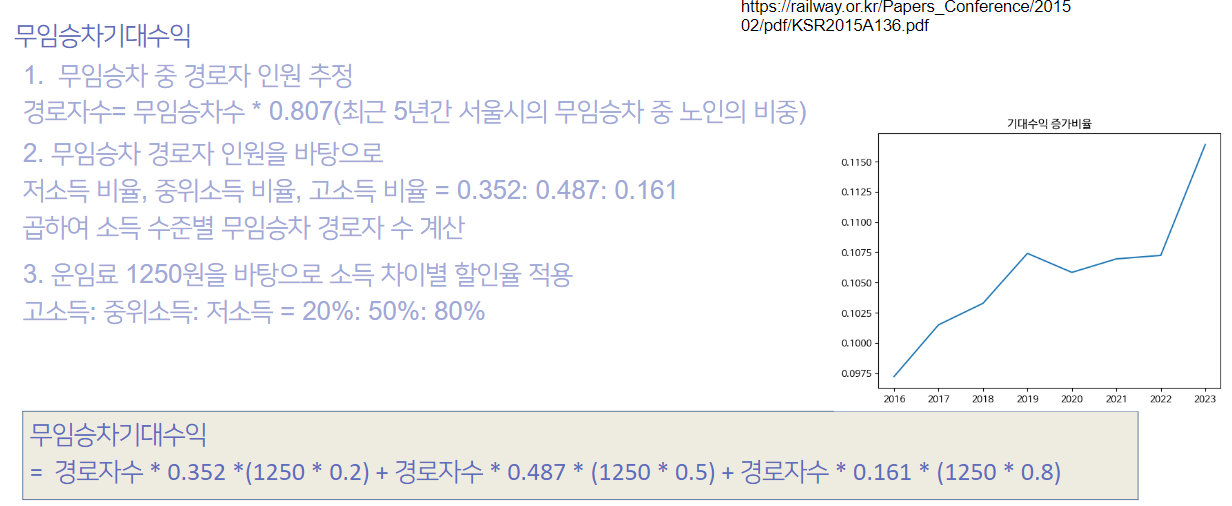


In [ ]:
df_finance['총수익'] = df_finance['수익'] + df_finance['영업외수익']
df_finance['총지출'] = df_finance['매출원가'] + df_finance['판매비와 관리비'] + df_finance['영업외비용']

# 손해액 또는 이득액 계산
df_finance['손해/이득액'] = df_finance['총수익'] - df_finance['총지출']

## 무임승차기대수익 계산 결과만 가져왔음.
df_finance['무임승차기대수익'] =  [1.776972e+11, 1.829950e+11, 1.865735e+11, 1.973320e+11, 1.408419e+11, 1.496892e+11, 1.717660e+11, 1.936304e+11]

In [ ]:
## finance dataframe check
df_finance

In [ ]:

# 65~69세에 교통비 100%를 모두 받은 경우
modified_df_finance['손해액'] = df_finance['손해액']
modified_df_finance['예상손해액(100%)'] = df_finance['손해액'] - free_riding
modified_df_finance['예상손해액(100%)'] = modified_df_finance['예상손해액(100%)'].round()
modified_df_finance['손해액감소율(100%)'] = modified_df_finance['예상손해액(100%)'] / df_finance['손해액']

# 65~69세 저소득층 40%를 제외한 60%만 받은 경우
modified_df_finance['예상손해액(60%)'] = df_finance['손해액'] - free_riding2
modified_df_finance['예상손해액(60%)'] = modified_df_finance['예상손해액(60%)'].round()
modified_df_finance['손해액감소율(60%)'] = modified_df_finance['예상손해액(60%)'] / df_finance['손해액']

modified_df_finance



### 조건별 수익성 비교



#### 조건 1 : 노령화 인구 전부 운행비용을 50% 받는 경우
- 무임승차 건수 X 1250 X 0.5로 계산


- 우리나라를 제외한 다른 주요국에서의 대중교통수단 할인 제도를 확인 가능.
- 보통은 할인 50%를 하거나, 가장 많이 몰리는 시간 이후에 무료로 전환, 혹은 연간 패스권이용
- https://i.namu.wiki/i/nJ9tw6M_mj8abHwRJaPIntfxxVOfWbVqFC-OWzA-QWGblJDosq2wdRoKFJXuabQImDcGOj3csW7iVyAzuL37Oe-_joWeIIXqGDhiNBhCvBDj2jEIBHEqLiFj-y4sFbPn2RD27cp0TZpTpgN_dCwDGQ.webp

In [ ]:
df_finance_con1 = df_finance.copy()
fee = 1250
ratio = 0.5

df_finance_con1

In [ ]:
income  = (annual_summary['무임승차'][:-1] * 1250 * 0.5) + df_finance_con1['손해/이득액']
# income

i = 0
for year in range(start_year, end_year):
    if income[i] > 0:
        print(f"{year}년의 수입이 더 큽니다. 손익금액은 {income[i]}원 입니다. ")
        i += 1
    else:
        print(f"{year}년의 지출이 더 큽니다. 손익금액은 {income[i]}원 입니다. ")
        i += 1

df_finance_con1['조건1_손해/이득액'] = income
df_finance_con1['조건1_감소율'] = round((1 - (df_finance_con1['조건1_손해/이득액']  / df_finance_con1['손해/이득액'] )) * 100, 2)

df_finance_con1



### 조건2 : 운수사업수익을 20% 상향(전체 교통비를 20% 상향된 상태로 똑같이 이용했을 때) 시켰을때  결과 도출

- 동일한 유임승차 횟수를 기반으로 산정
- 물론 상승된 교통비에 따른 이용률에 변화가 있을 수 있지만, 우선적으로 동일한 사용횟수에서 얼마큼의 차이가 존재하는지 확인하기 위해서 분석
- 교통비를 20% 상향했다고 가정(2016~2023년은 일반인 기준 1250원)


In [ ]:
df_finance_con2 = df_finance.copy()
df_finance_con2

In [ ]:
# 2016 ~ 2023 일반인 기준 운임비용 1250원
df_finance_con2['조건2_수익'] = df_finance_con2['총수익'] + (df_finance_con2['운수사업수익']*0.2)
df_finance_con2['조건2_손해/이득액'] = df_finance_con2['조건2_수익'] - df_finance_con2['총지출']
df_finance_con2['조건2비용감소율'] = round((1 - (df_finance_con2['조건2_손해/이득액'] / df_finance_con2['손해/이득액']))* 100, 2)

df_finance_con2


In [ ]:
## 조건2 plotting
# 중앙선 그리기
plt.figure(figsize=(12, 6))
x = df_finance_con2['연도']

y = df_finance_con2['조건2_손해/이득액']
plt.axhline(0, color='black', linewidth=1)

# 중앙선을 기준으로 위, 아래로 나뉘는 막대 그래프 그리기
plt.bar(x, y, color=np.where(y>=0, 'blue', 'red'), alpha=0.5)
plt.title("조건에 따른 손해/이득액")
plt.xlabel("연도")
plt.ylabel("금액")
plt.show()


### 조건3 : 운임비용(+25%) + 65~69세 운임비용

- 서울교통공사가 계획중인 1550원대를 맞추려면 1250원에서 1.25배하면 정확하진 않지만 유사하게 맞출 수 있음.
- 추가적으로 서울시에서 조사한 내용에 따르면 65세 이후에 경제 활동에 참여하는 인구 비율 증가에 따른, 교통비 지불에 있어서 반감이 있을 수는 있지만, 어느정도 부담이 적을 것으로 판단됨


In [ ]:
df_finance_con3 = df_finance.copy()
con_prob = 0.25
subway_fee = 1250

df_finance_con3

In [ ]:
condition1_income =  round((annual_summary['유무임승차'][:-1] * df_older['65~69세 비율']), 0) * subway_fee * (1+ con_prob)
# condition1_income

condition2_income = df_finance_con3['운수사업수익']*con_prob
# condition2_income

df_finance_con3['조건3_총수익'] = df_finance_con3['총수익'] + condition1_income + condition2_income
df_finance_con3['조건3_손해/이득액'] = df_finance_con3['조건3_총수익'] - df_finance_con3['총지출']

df_finance_con3

In [ ]:
## 조건3 plotting
# 중앙선 그리기
plt.figure(figsize=(12, 6))
x = df_finance_con3['연도']

y = df_finance_con3['조건3_손해/이득액']
plt.axhline(0, color='black', linewidth=1)

# 중앙선을 기준으로 위, 아래로 나뉘는 막대 그래프 그리기
plt.bar(x, y, color=np.where(y>=0, 'blue', 'red'), alpha=0.5)
plt.title("조건에 따른 손해/이득액")
plt.xlabel("연도")
plt.ylabel("금액")
plt.show()

print(f"조건 3의 손해/이득액의 합산은  {df_finance_con3['조건3_손해/이득액'].sum()}원 입니다.")

### 조건4 : 상승한 운임비용(25%) + 노령인구 전체에 운임비용 50%

- 노령인구 전체에 운임비용 50%를 부과한 경우 + 기본 1250원에서 약 25% 상승한 요금을 받았을 경우.
- 가장 반발이 클 것으로 예상되며, 거의 실현이 불가능하다고 판단되어짐.
- 대략적인 금액에 대한 수치를 확인 하기 위하여 조건부 확인


In [ ]:
df_finance_con4 = df_finance.copy()
con_prob = 0.25
con1_prob = 0.5
subway_fee = 1250

df_finance_con4

In [ ]:
condition1_income  = (annual_summary['무임승차'][:-1] * (1250*(1+con_prob)) * con1_prob)
condition1_income

condition2_income = df_finance_con4['운수사업수익']*con_prob
condition2_income

df_finance_con4['조건4_총수익'] = df_finance_con4['총수익'] + condition1_income + condition2_income
df_finance_con4['조건4_손해/이득액'] = df_finance_con4['조건4_총수익'] - df_finance_con4['총지출']

df_finance_con4

In [ ]:
## 조건4 plotting

# 중앙선 그리기
plt.figure(figsize=(12, 6))
x = df_finance_con4['연도']

y = df_finance_con4['조건4_손해/이득액']
plt.axhline(0, color='black', linewidth=1)

# 중앙선을 기준으로 위, 아래로 나뉘는 막대 그래프 그리기
plt.bar(x, y, color=np.where(y>=0, 'blue', 'red'), alpha=0.5)
plt.title("조건에 따른 손해/이득액")
plt.xlabel("연도")
plt.ylabel("금액")
plt.show()

print(f"조건 4의 손해/이득액의 합산은 {df_finance_con4['조건4_손해/이득액'].sum()}원 입니다.")


### 조건 5 : 상승된 운임금액(25%) + 차등부과

- 민지님이 조사해주신 내용을 통해서 노령인구에서 소득에 따른 운임비용 차등 부과


In [ ]:
df_finance_con5 = df_finance.copy()
con_prob = 0.25
subway_fee = 1250

df_finance_con5

In [ ]:
df_finance_con5['조건5_총수익'] = df_finance_con5['총수익'] + (df_finance_con5['운수사업수익']* 0.25) + df_finance_con5['무임승차기대수익']

df_finance_con5

df_finance_con5['조건5_손해/이득액'] = df_finance_con5['조건5_총수익'] - df_finance_con5['총지출']
df_finance_con5

print(f"조건 5의 손해/이득액의 합산은 {df_finance_con5['조건5_손해/이득액'].sum()}원 입니다.")

In [ ]:
## 조건5 plotting
# 중앙선 그리기
plt.figure(figsize=(12, 6))
x = df_finance_con5['연도']

y = df_finance_con5['조건5_손해/이득액']
plt.axhline(0, color='black', linewidth=1)

# 중앙선을 기준으로 위, 아래로 나뉘는 막대 그래프 그리기
plt.bar(x, y, color=np.where(y>=0, 'blue', 'red'), alpha=0.5)
plt.title("조건에 따른 손해/이득액")
plt.xlabel("연도")
plt.ylabel("금액")
plt.show()



## 그외 잡다한 것

### 선기님 데이터 셋 구축
- 년도 월에 따른 유임승차 비율 도출

예시) 2016년 1월의 유임승차의 비율은 2016년 전체 유임승차인원의 비율에서 몇%를 차지하는지에 대해서 비율 도출


In [ ]:
# 연도별 유임승차, 무임승차, 무임승차비율, 유무임승차(유임승차 + 무임승차) 데이터 셋
annual_summary

# 년 월에 따른 데이터 셋
df_month

# 결과를 저장할 새로운 데이터프레임 생성
df_ratio = pd.DataFrame()

for year in range(start_year, end_year + 1):
    # 해당 년도의 전체 유임승차 합계
    total_fare_paying = annual_summary[annual_summary['연도'] == year]['유임승차'].values[0]

    # 해당 년도의 각 월별 유임승차 합계
    df_month_year = df_month[df_month['년월'].str.startswith(str(year))]

    # 각 월별 유임승차 합계가 전체 유임승차에 대해 차지하는 비율을 계산
    df_month_year['유임승차비율(%)'] = df_month_year['유임승차 합계'] / total_fare_paying * 100

    # df_ratio에 df_month_year를 추가
    df_ratio = pd.concat([df_ratio, df_month_year], ignore_index=True)

df_ratio

df_ratio.to_csv("df_month_pay_ratio.csv", index=False, encoding='cp949')

In [ ]:
df_ratio
df_ratio[-16:]

In [ ]:
## 유임승차 추이 plotting
sns.lineplot(x=df_ratio[-16:]['년월'], y=df_ratio[-16:]['유임승차 합계'], marker='o')
plt.ylim([1.0e8, 2.0e8])
plt.grid(True)
plt.title('2023년 3월 ~ 2024년 6월 유임승차 추이')
plt.xticks(ticks=range(len(df_ratio[-16:])),  rotation=45)
plt.show()


### 민지님 데이터 가공
- 연도별 운수사업수익 및 이용객수 관련


In [ ]:
new_df = pd.concat([annual_summary[:-1], df_finance['운수사업수익']], axis=1)

new_df.to_csv('subway_data.csv', encoding = 'cp949')


### 연도별 손해액 plot


In [ ]:
plot_finance = df_finance.copy()
plot_finance['손해/이득액'] = plot_finance['손해/이득액'] / 1e8

In [ ]:

# 중앙선 그리기
plt.figure(figsize=(12, 6))
x = plot_finance['연도']
y = plot_finance['손해/이득액']
plt.axhline(0, color='black', linewidth=1)

# 중앙선을 기준으로 위, 아래로 나뉘는 막대 그래프 그리기
bars = plt.bar(x, y, color=np.where(y >= 0, 'blue', 'red'), alpha=0.5)

# 막대 위에 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom' if height >= 0 else 'top')

plt.title("손해/이득액", fontsize=20)
plt.xlabel("연도", fontsize=16)
plt.ylabel("금액(억)", fontsize=16)
plt.show()
